### This notebook is for learning about tf.data.

I'm starting by following the tf data tutorial from offical website: https://www.tensorflow.org/guide/data

This will be useful for training DeepSonar.

#### Consuming sets of files

In [2]:
import os
for_data_path = "D:/for-norm"
os.path.exists(for_data_path)

True

In [3]:
import pathlib
for_data_path = pathlib.Path(for_data_path)

In [4]:
for item in for_data_path.glob("*"):
    print(item.name)

testing
training
validation


In [5]:
import tensorflow as tf
list_ds = tf.data.Dataset.list_files(str(for_data_path/'*/*'))

In [6]:
for f in list_ds.take(5):
    print(f.numpy())

b'D:\\for-norm\\validation\\fake'
b'D:\\for-norm\\training\\real'
b'D:\\for-norm\\testing\\fake'
b'D:\\for-norm\\testing\\real'
b'D:\\for-norm\\training\\fake'


In [7]:
# need to go one level deeper to match example
train_path = "D:/for-norm/training/"
train_path = pathlib.Path(train_path)
for item in train_path.glob("*"):
    print(item.name)

fake
real


In [8]:
list_ds = tf.data.Dataset.list_files(str(train_path/'*/*'))

for f in list_ds.take(5):
    print(f.numpy())

b'D:\\for-norm\\training\\fake\\file9388.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\real\\file34262.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\real\\file21169.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\fake\\file16823.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'
b'D:\\for-norm\\training\\fake\\file4608.mp3.wav_16k.wav_norm.wav_mono.wav_silence.wav'


In [9]:
def process_path(file_path):
    label = tf.strings.split(file_path, os.sep)[-2]
    return tf.io.read_file(file_path), label

labeled_ds = list_ds.map(process_path)

In [10]:
for audio_raw, label_text in labeled_ds.take(1):
    print(repr(audio_raw.numpy()[:100]))
    print()
    print(label_text.numpy())

b'RIFF\xcc\x8b\x01\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80>\x00\x00\x00}\x00\x00\x02\x00\x10\x00data\xa8\x8b\x01\x00\xf7\x06\xac\x08]\r\x9a\x0c\'\n\x95\x04\xe2\x01t\x02\x05\x00|\x01\xf5\x03\xae\xff\x91\xfbk\xfbF\xfb"\xfc\xc6\xf9\xe9\xf6\xec\xf6Z\xf8[\xfc\xd6\xfd=\xfdz\xfb\xe6\xf9\xcb\xf7s\xfb\xfc\x00'

b'real'


#### Batching

- Batching tensors with padding: for when tensors have different lengths, e.g., the voice data

In [11]:
batched_dataset = labeled_ds.batch(4)

for batch in batched_dataset.take(1):
    print(len([arr.numpy() for arr in batch][0]))

4


In [12]:
batched_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [13]:
labeled_ds.batch(7, drop_remainder=True)

<BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.string, name=None), TensorSpec(shape=(7,), dtype=tf.string, name=None))>

In [14]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))

# pads each element in each batch
dataset = dataset.padded_batch(3, padded_shapes=(None,))

for batch in dataset.take(2):
    print(batch.numpy())
    print()

[[0 0]
 [1 0]
 [2 2]]

[[3 3 3 0 0]
 [4 4 4 4 0]
 [5 5 5 5 5]]



#### Epochs

In [15]:
titanic_file = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [16]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [17]:
def plot_batch_sizes(ds):
    batch_sizes = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')

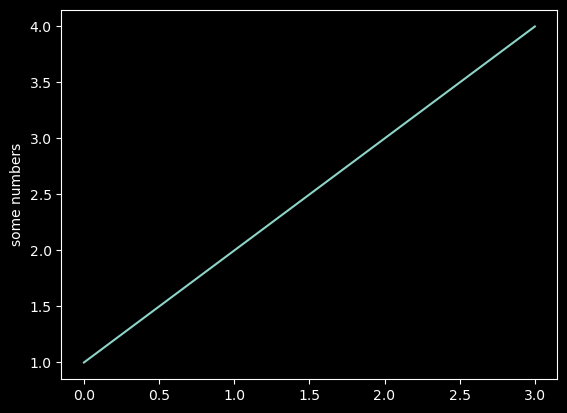

In [18]:
import matplotlib.pyplot as plt
plt.plot([1, 2, 3, 4])
plt.ylabel('some numbers')
plt.show()

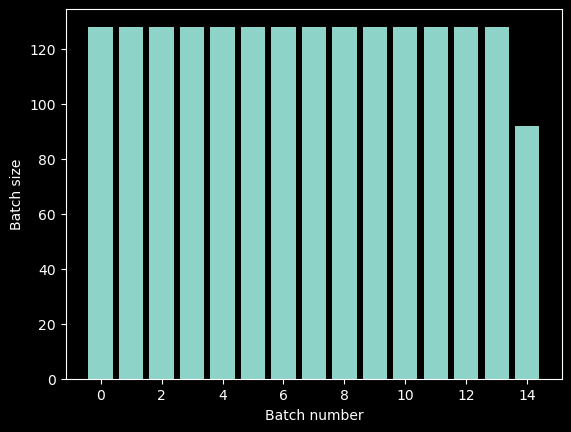

In [19]:
# repeat before batch => "batches straddle epoch boundaries"
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_sizes(titanic_batches)

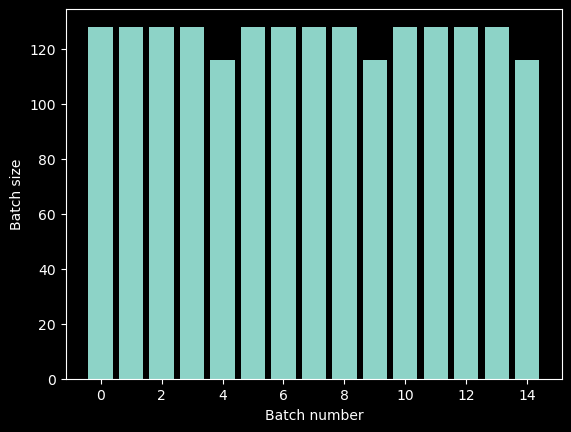

In [20]:
# repeat after batch => "clear epoch separation"
titanic_batches = titanic_lines.batch(128).repeat(3)

plot_batch_sizes(titanic_batches)

In [21]:
epochs = 3
dataset = titanic_lines.batch(128)

for epoch in range(epochs):
    for batch in dataset:
        print(batch.shape)
    print("End of epoch: ", epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch:  2


#### Random shuffling

In [22]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter() # indexes in dataset

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [23]:
n,line_batch = next(iter(dataset))
print(n.numpy())

[ 50  51  47  48  22  81  40  36  70  30 100  66  67  87 108   2  57  28
  69  24]


In [24]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(60).take(5):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[620 562 594 606 519 471 539 483 603 619]
[588 510 535 623 587 378 479 614 593 527]
[605 533 546 466 330 512 581 626]
[13 90  1 55 50 61  3 39 85 34]
[10 63 94 97 48 54 88  8 52 25]


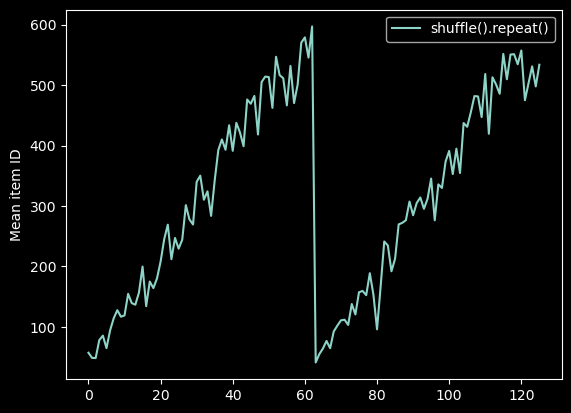

In [25]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.ylabel("Mean item ID")
plt.legend()

In [26]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boundary:\n")
for n, line_batch in shuffled.skip(55).take(15):
    print(n.numpy())

Here are the item ID's near the epoch boundary:

[  1 514 618 486 568 610 468 466 589 537]
[615  17  29  28 624   5  30 484 527 600]
[  3 577  23 575 598 609 485 616 110 495]
[415   9  27  45 543 596  47  32  10 560]
[ 54  24 508  12  22 595 555  19  15 574]
[ 39  51 518  60 620  26  75 626   4  36]
[529  77 627  62 562  55  48  16 580 456]
[ 25  68  59  43  33 572 454 444  14  84]
[608 591  92  94 567 581  44  82 336 594]
[ 52 492 273  78  70 553  42 549 548  13]
[479  49  37 120  58  69  63  80  76 114]
[108 125 101 123  65  99 623 117 129 128]
[536 137 541   7  67 474  40  64  46 112]
[ 34 604 115 142 528 144 621  86  95 134]
[ 53 121  98 611 119 603 148 113 606 147]


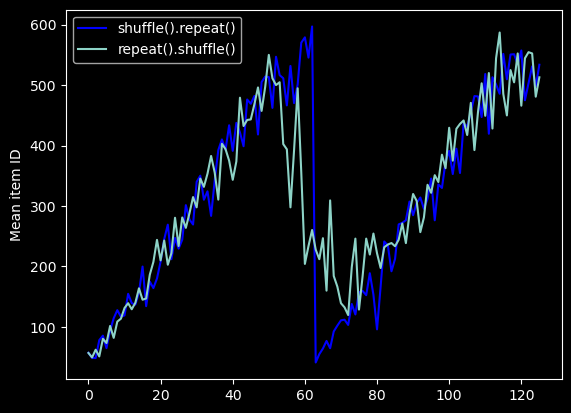

In [27]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]

plt.plot(shuffle_repeat, 'b', label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.ylabel("Mean item ID")
plt.legend()

#### Data prep

In [28]:
flowers_root = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)
flowers_root = pathlib.Path(flowers_root)

In [29]:
list_ds = tf.data.Dataset.list_files(str(flowers_root/'*/*'))

In [30]:
# Reads an image from a file, decodes it into a dense tensor, and resizes it
# to a fixed shape.
def parse_image(filename):
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label

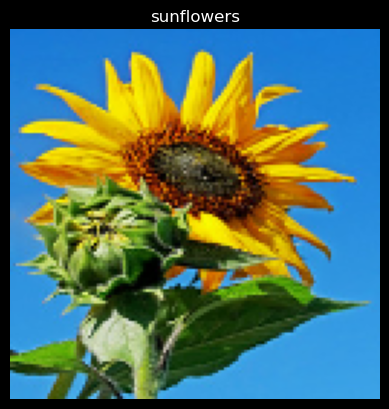

In [31]:
file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

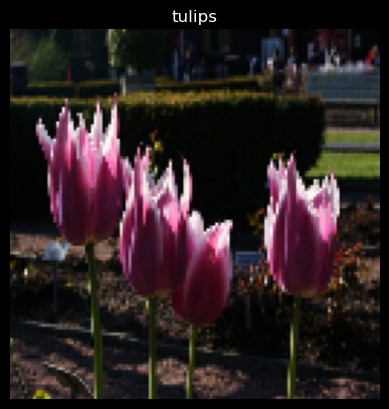

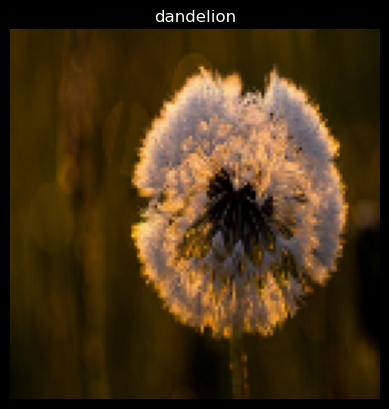

In [32]:
images_ds = list_ds.map(parse_image)

for image, label in images_ds.take(2):
    show(image, label)

In [33]:
import scipy.ndimage as ndimage
import numpy as np

# should use tf operations whenever possible for speed
def random_rotate_image(image):
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


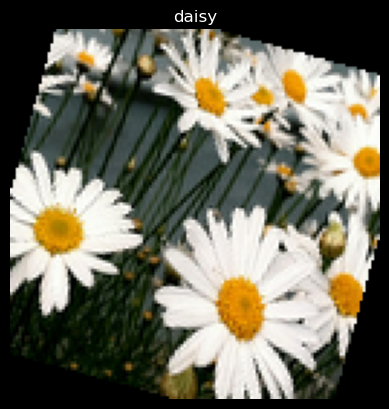

In [34]:
image, label = next(iter(images_ds))
image = random_rotate_image(image)
show(image, label)

In [35]:
def tf_random_rotate_image(image, label):
    im_shape = image.shape
    [image,] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


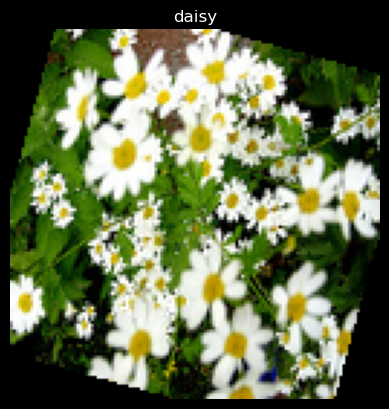

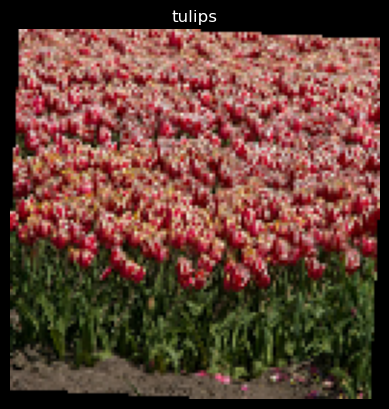

In [36]:
rot_ds = images_ds.map(tf_random_rotate_image)

for image, label in rot_ds.take(2):
    show(image, label)

#### tf data + keras

In [37]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0
labels = labels.astype(np.int32)

4422102/4422102 [==============================] - 0s 0us/step


In [38]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [39]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6011 - accuracy: 0.7976
Epoch 2/2
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4626 - accuracy: 0.8417


In [40]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4467 - accuracy: 0.8500
Epoch 2/2
20/20 [==============================] - 0s 2ms/step - loss: 0.4507 - accuracy: 0.8516


In [41]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print("Loss :", loss)
print("Accuracy :", accuracy)

1875/1875 [==============================] - 2s 1ms/step - loss: 0.4327 - accuracy: 0.8533
Loss : 0.4326697289943695
Accuracy : 0.8532500267028809


In [42]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps=10)
print("Loss :", loss)
print("Accuracy :", accuracy)

10/10 [==============================] - 0s 3ms/step - loss: 0.4623 - accuracy: 0.8313
Loss : 0.4622587263584137
Accuracy : 0.831250011920929


In [43]:
predict_ds = tf.data.Dataset.from_tensor_slices(images).batch(32)
result = model.predict(predict_ds, steps = 10)
print(result.shape)

10/10 [==============================] - 0s 2ms/step
(320, 10)


In [44]:
# can either pass the labels or not
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

10/10 [==============================] - 0s 2ms/step
(320, 10)
